## This script shows how the analysis is done and how plots are created

In [1]:
# import all required modules

%pylab inline

import netCDF4
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

from pathlib import Path

from hypercc.data.box import Box
from hypercc.data.data_set import DataSet
from hypercc.units import unit
from hypercc.plotting import (
    plot_mollweide, plot_orthographic_np, plot_plate_carree, earth_plot,
    plot_signal_histogram)
from hypercc.filters import (taper_masked_area, gaussian_filter, sobel_filter)
from hypercc.calibration import (calibrate_sobel)

Populating the interactive namespace from numpy and matplotlib


## Enter your settings here

In [2]:
###### settings for idealised testcases
data_folder = Path("/home/bathiany/Sebastian/datamining/edges/testcases")
variable = "test777"     
model = "MIROC-ESM"      # load CMIP5 simulation just to have info on space and time; data will be replaced
quartile_calibration=3    #4
####

# which month should be selected for the yearly time series (1-12; 13 is annual mean)
month = 7

## smoothing scales
sigma_d = unit('200 km')     # space
sigma_t = unit('5 year')    # time


# select data based on settings above
## No editing below this point required

In [3]:
data_set = DataSet.cmip5(
    path=data_folder,
    model=model, 
    variable=variable,
    scenario='rcp85',      # climate change scenario, here: rcp85
    realization='r1i1p1',  # realisation 
)[month-1::12]

data_set.load()

## Load and inspect the data

Next we define a `box`. The box contains all information on the geometry of the data. It loads the lattitudes and longitudes of the grid points from the NetCDF file and computes quantities like resolution.

In [4]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(1.0 year, 310.239 km, 312.736 km) per pixel
2006-07-16, 2007-07-16, 2008-07-16,  ...
time steps: max 366.0 min 365.0


The ``Box`` class has the nice feature that you can select slices from it, and the information will adapt. The data we loaded contains monthly snapshots. If we select one snapshot in twelve, we obtain yearly data for that month. The ``Box`` class stores the axis grid points internally and slices the time axis accordingly.

## # create test data

In [5]:
control_set = DataSet.cmip5(
    path=data_folder, model=model, variable=variable,
    scenario='piControl', realization='r1i1p1')[month-1::12]

control_data = control_set.data  
control_box = control_set.box


In [6]:
piControl=control_data*0.0
climchange=control_data*0.0

lons=np.size(piControl,2)
lats=np.size(piControl,1)
times=np.size(piControl,0)

yearvec=linspace(1,times,times)

time_ini=0.45
time_fin=0.55

lat_ini=0.7
lat_fin=0.9
lon_ini=0.05
lon_fin=0.2

amplitude=4

lat_ini_index=max(round(lat_ini*lats),1)
lat_fin_index=max(round(lat_fin*lats),1)
lon_ini_index=max(round(lon_ini*lons),1)
lon_fin_index=max(round(lon_fin*lons),1)
time_ini_index=max(round(time_ini*times),1)
time_fin_index=max(round(time_fin*times),1)

lat_range=lat_fin-lat_ini
lon_range=lon_fin-lon_ini
time_range=time_fin-time_ini

lat_mid=(lat_ini+lat_fin)/2
lon_mid=(lon_ini+lon_fin)/2
time_mid=(time_ini+time_fin)/2
lat_mid_index=round(lat_mid*lats)
lon_mid_index=round(lon_mid*lons)
time_mid_index=round(time_mid*times)


In [7]:
for timeind in range(time_ini_index,time_fin_index+1):
    if timeind < time_mid_index:
        weight_time=(timeind-time_ini_index)/(time_mid_index-time_ini_index)
    else:
        weight_time=(time_fin_index-timeind)/(time_fin_index-time_mid_index)
  
    for lonind in range(lon_ini_index,lon_fin_index+1):
        if lonind < lon_mid_index:
            weight_lon=(lonind-lon_ini_index)/(lon_mid_index-lon_ini_index)
        else:
            weight_lon=(lon_fin_index-lonind)/(lon_fin_index-lon_mid_index)

        for latind in range(lat_ini_index,lat_fin_index+1):
            if latind < lat_mid_index:
                weight_lat=(latind-lat_ini_index)/(lat_mid_index-lat_ini_index)
            else:
                weight_lat=(lat_fin_index-latind)/(lat_fin_index-lat_mid_index)

            climchange[timeind,latind,lonind]=amplitude*weight_time*weight_lon*weight_lat;

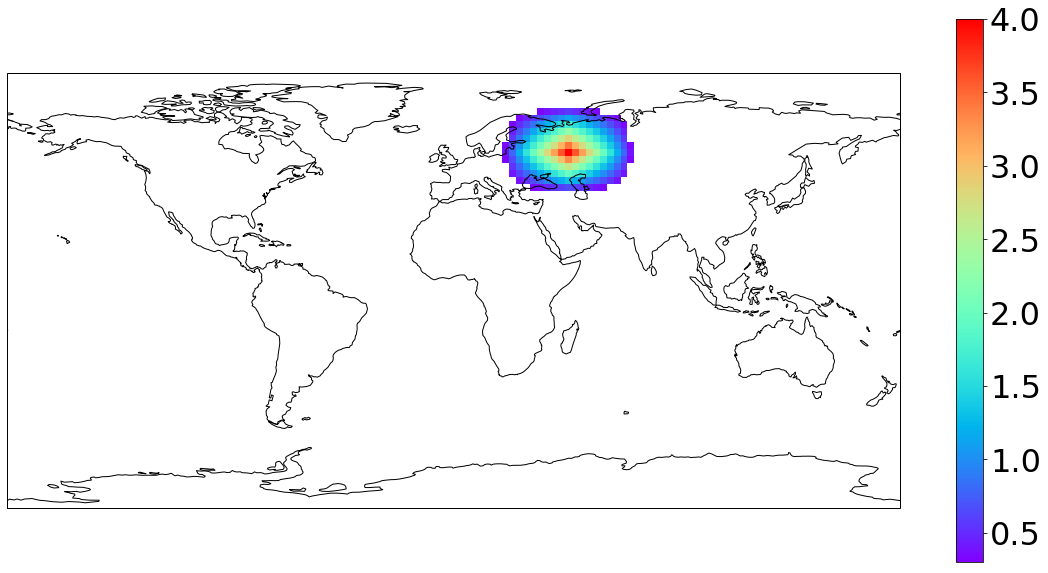

In [8]:
# climchange data during extreme event (without noise)

my_cmap = matplotlib.cm.get_cmap('rainbow')
matplotlib.rcParams['figure.figsize'] = (25,10)
my_cmap.set_under('w')

#plt.tick_params(axis='both', which='major', labelsize=32)

matplotlib.rcParams.update({'font.size': 32})
plot_plate_carree(box, climchange[time_mid_index,:,:], cmap=my_cmap, vmin=0.3)

In [9]:
# add noise:
sigma=1  # noise level

noise_var=sigma*randn(times,lats,lons)
noise_piControl=sigma*randn(times,lats,lons)
climchange=climchange+noise_var
piControl=piControl+noise_piControl 

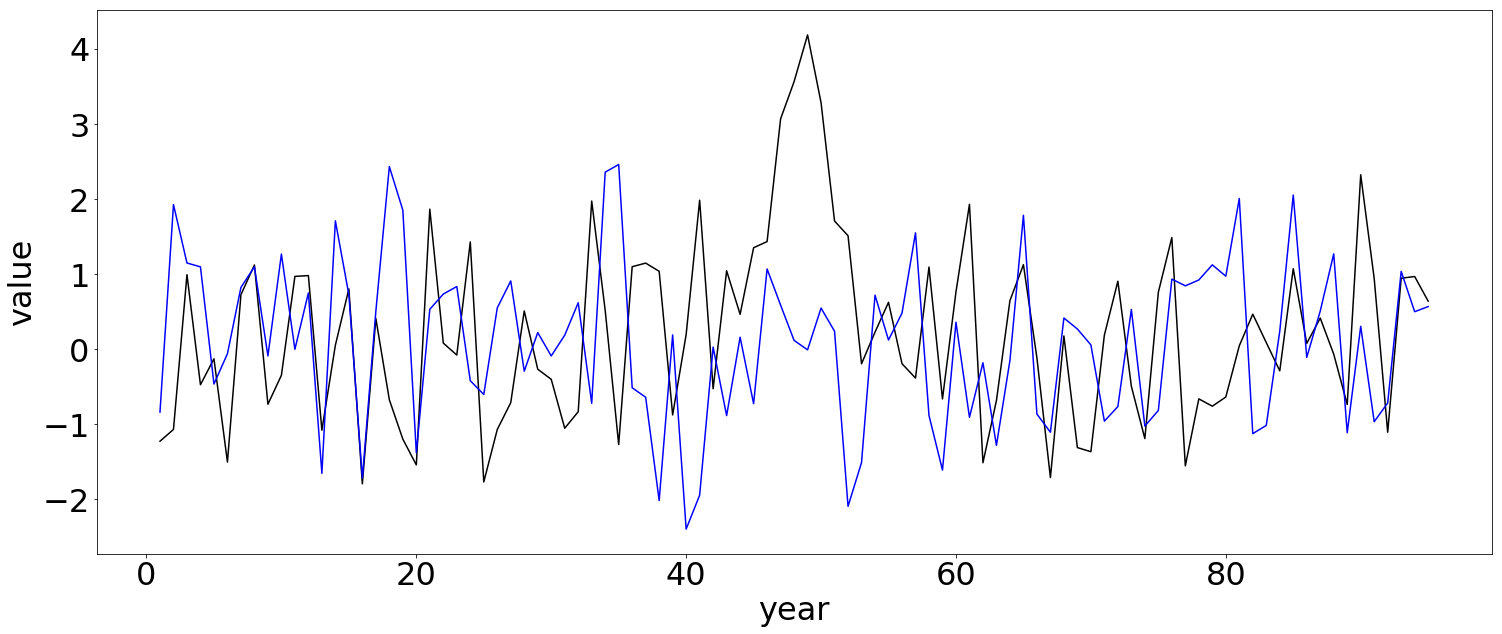

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(yearvec, climchange[:,lat_mid_index,lon_mid_index], 'k')
ax.plot(yearvec, piControl[:,lat_mid_index,lon_mid_index],'b')

plt.xlabel('year', fontsize=32)
plt.ylabel('value', fontsize=32)

plt.tick_params(axis='both', which='major', labelsize=32)
#saveas(gcf,['test_timeseries_int'],'pdf')

In [11]:
## time integral for each place:
##### 2 do: integration should be on the timescale sigma_t !!

climchange_int=control_data*0.0
piControl_int=control_data*0.0

for lonind in range(0,lons):
    for latind in range(0,lats):
        for timeind in range(0,times):
            climchange_int[timeind,latind,lonind]=np.sum(climchange[0:timeind,latind,lonind])
            piControl_int[timeind,latind,lonind]=np.sum(piControl[0:timeind,latind,lonind])


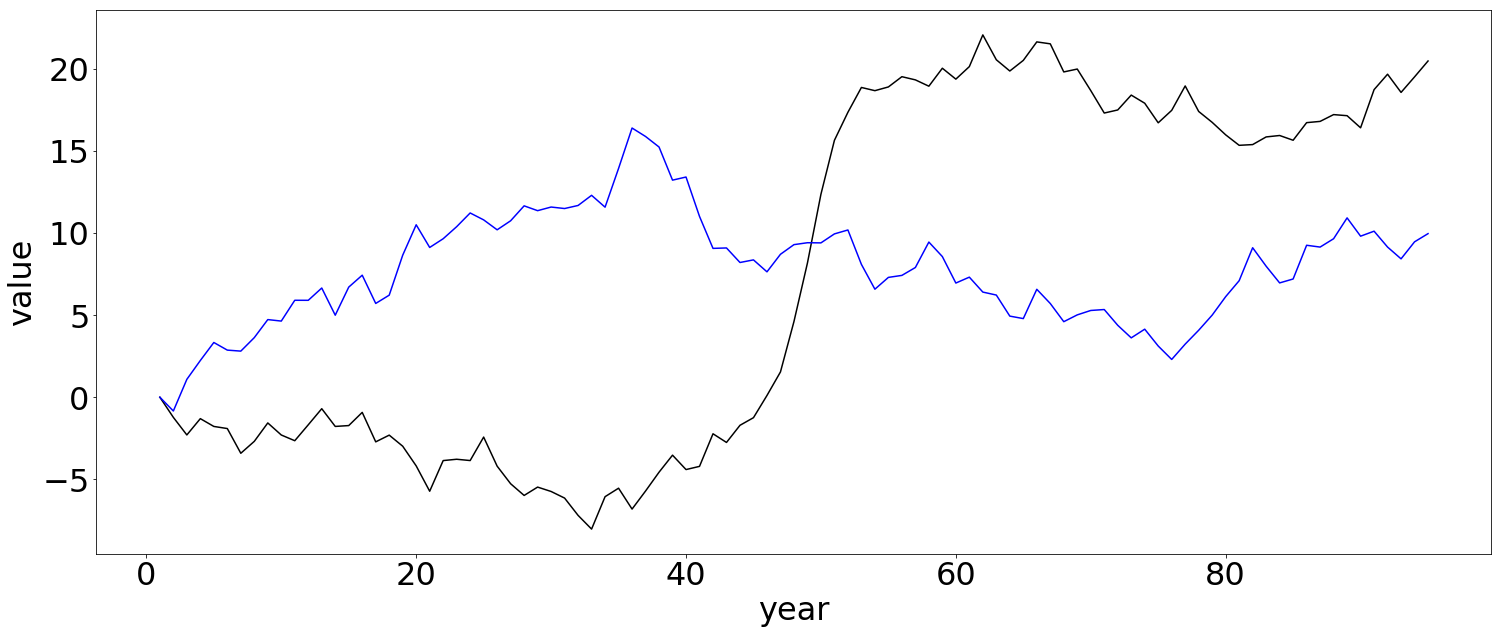

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(yearvec, climchange_int[:,lat_mid_index,lon_mid_index], 'k')
ax.plot(yearvec, piControl_int[:,lat_mid_index,lon_mid_index],'b')

plt.xlabel('year', fontsize=32)
plt.ylabel('value', fontsize=32)

plt.tick_params(axis='both', which='major', labelsize=32)

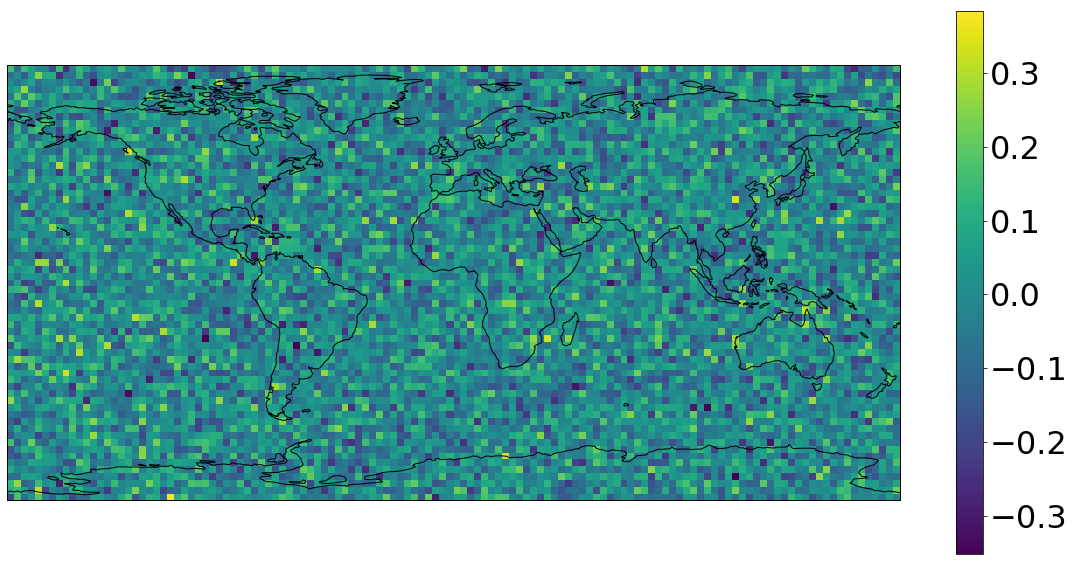

In [13]:
# time mean control data
meanctl=np.mean(piControl, axis=0)
plot_plate_carree(box, meanctl)

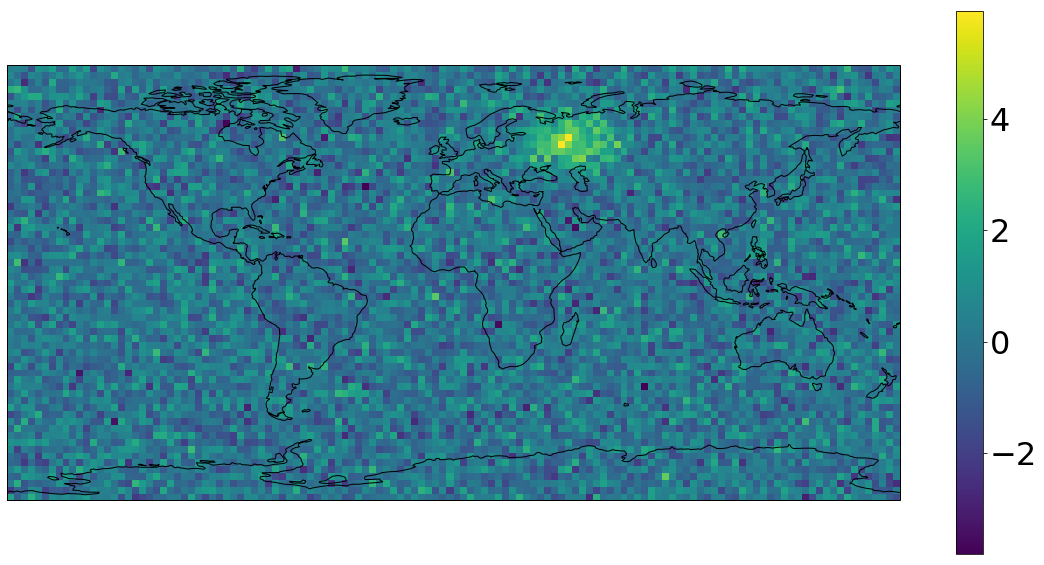

In [14]:
# climchange data during extreme event
plot_plate_carree(box, climchange[time_mid_index,:,:])

## calibration of space and time

In [15]:
control_data=piControl_int #_detrended

In [16]:
smooth_control_data = gaussian_filter(control_box, control_data, [sigma_t, sigma_d, sigma_d])

In [17]:
# scaling_factor is the aspect ratio between space and time
# Here it is initialised as 1, but will be calibrated automatically later
scaling_factor = unit('1 km/year')
sobel_delta_t = unit('1 year')                    # time scale
sobel_delta_d = sobel_delta_t * scaling_factor    # length scale
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

In [18]:
calibration = calibrate_sobel(quartile_calibration, control_box, smooth_control_data, sobel_delta_t, sobel_delta_d)

for k, v in calibration.items():
    print("{:10}: {}".format(k, v))
print("recommended setting for gamma: ", calibration['gamma'][quartile_calibration])   #orig: 3

time      : [1.0523945e-07 3.2264870e-02 7.3983014e-02 1.3386703e-01 5.7237661e-01]
gamma     : [0.01317127 5.9759307  7.3984776  8.274348   9.065383  ]
magnitude : [6.1635568e-08 2.1802867e-03 6.5538362e-03 1.8227361e-02 3.2761857e-01]
distance  : [7.9900774e-06 5.3991373e-03 9.9997614e-03 1.6178558e-02 6.3138708e-02]
recommended setting for gamma:  8.274348


In [19]:
sb_control = sobel_filter(control_box, smooth_control_data, weight=sobel_weights)
pixel_sb_control = sobel_filter(control_box, smooth_control_data, physical=False)
pixel_sb_control[3] = sb_control[3]

signal_control = (1.0 / sb_control[3])

In [20]:
gamma_cal = calibration['gamma'][quartile_calibration]   #default in hypercc: 3

## here put all weight on time
#gamma_cal=0.00000001

scaling_factor = gamma_cal * unit('1 km/year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

In [21]:
#np.percentile(tgrad, [25, 50, 75, 100])

signalarray = np.asarray(signal_control).reshape(-1)
signal_no0 = np.ma.masked_equal(signalarray,0)
signal_no0=signal_no0.compressed()
np.percentile(signal_no0, [25, 50, 75, 100])

array([0.02885107, 0.0634372 , 0.11977408, 0.57253897])

In [43]:
## defining the threshold parameters for hysteresis thresholding:
# each pixel with a the gradient above the upper threshold is labeled as a strong edge.
# each pixel that is above the lower threshold is labeled as a weak edge.
# all strong edges are kept as edges.
# all weak edges that are connected to strong edges are kept as edges, the others are dropped.

## calibrate with piControl simulation
# set upper threshold as the combination of the maxima of gradients in space and time
#mag_quartiles=np.sqrt((calibration['distance'] * gamma_cal)**2 + calibration['time']**2)
#upper_threshold = mag_quartiles[4]

## calibrate using data itself
upper_threshold=4*np.percentile(signal_no0, 95)
# set lower threshold to be half the upper threshold
lower_threshold = upper_threshold/2

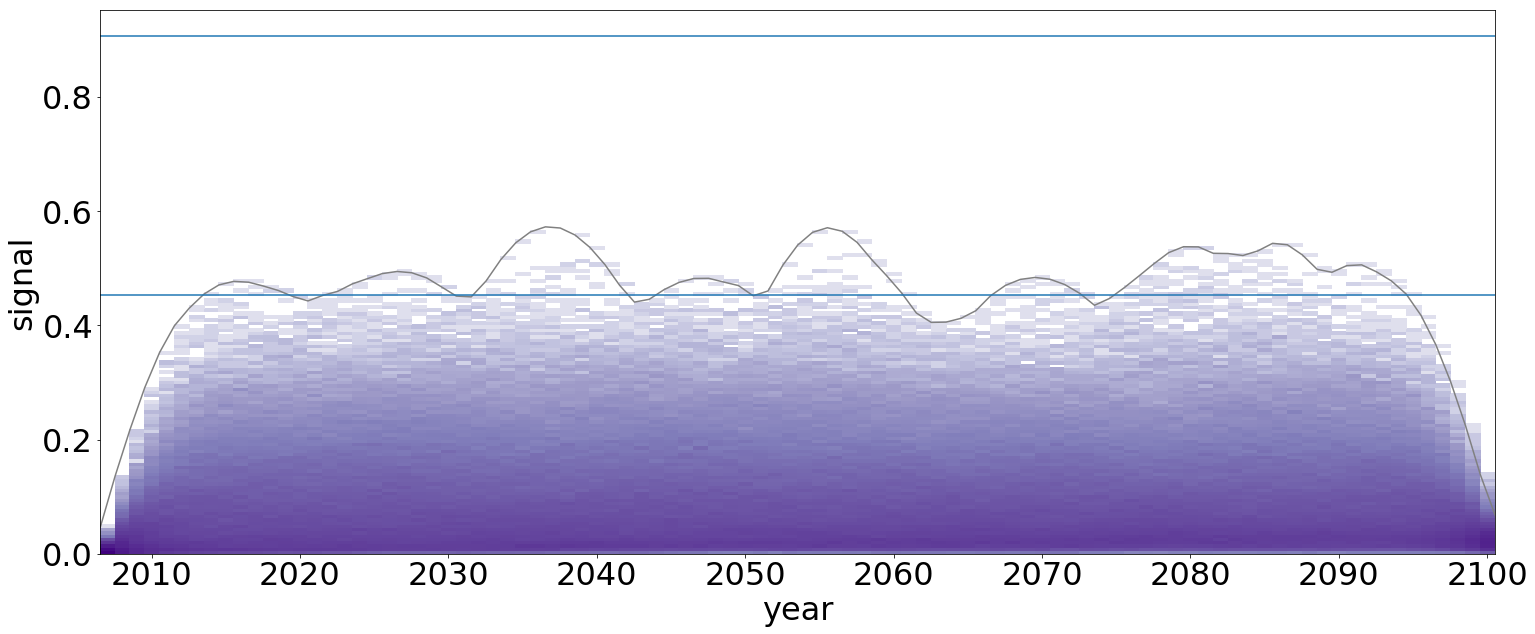

In [44]:
plot_signal_histogram(control_box, signal_control, upper_threshold, lower_threshold);

## Canny edges

The Canny edge detector consists of four stages:

* Smoothing
* Differentiating (Sobel operator)
* Non-maximum suppression
* Hysteresis thresholding

The first two of these stages are sensitive to the geometry of the information. How data is smoothed or differentiated is influenced by the spherical projection of our data. In this method we assume a Plate-Carree projection, where lattitudes and longitudes are mapped to a 1:2 rectangle with equal number of degrees per pixel everywhere. We may test this assumption on our ``box`` object.

In [45]:
box.rectangular

True

### Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [46]:
#data = data_set.data
data=climchange_int #_detrended
yearly_box = box[month-1::12]

smooth_data = gaussian_filter(box, data, [sigma_t, sigma_d, sigma_d])


### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [47]:
sb = sobel_filter(box, smooth_data, weight=sobel_weights)
pixel_sb = sobel_filter(box, smooth_data, physical=False)
pixel_sb[3] = sb[3]

### Determine hysteresis settings

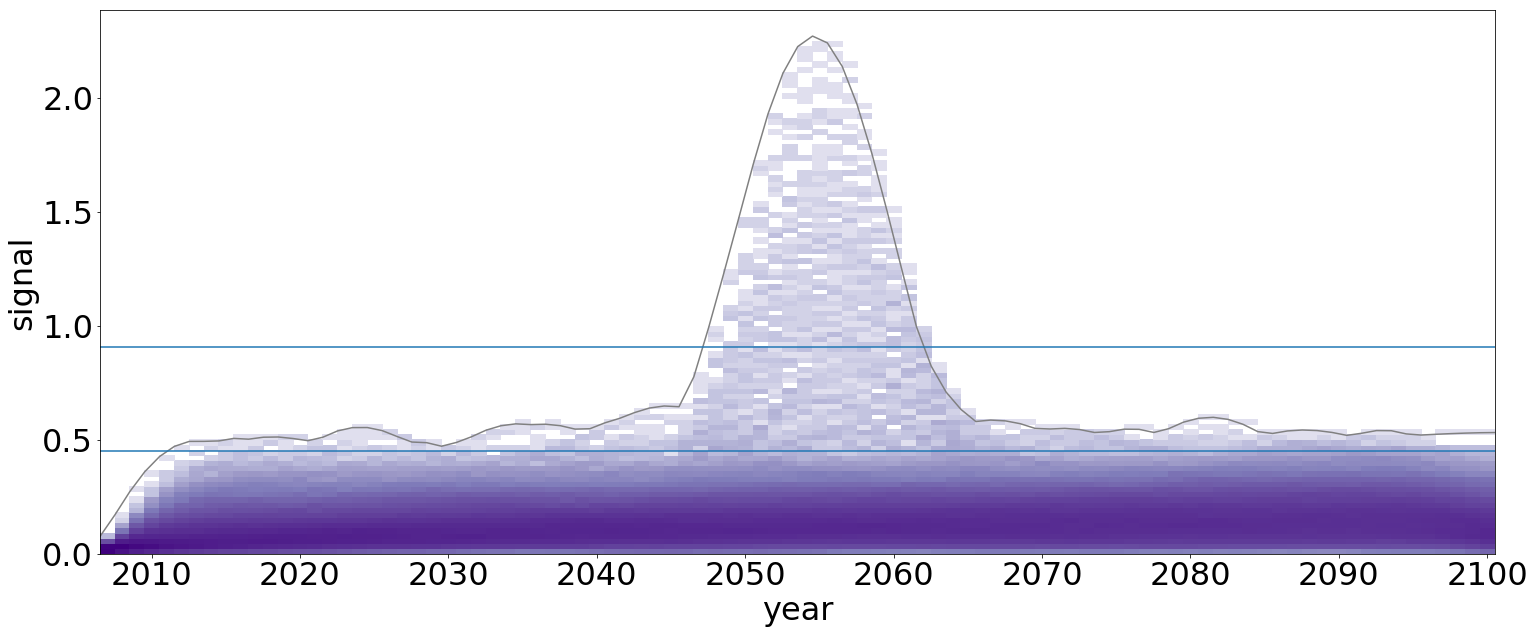

In [48]:
signal = (1.0 / sb[3])

plot_signal_histogram(box, signal, upper_threshold, lower_threshold);

matplotlib.rcParams.update({'font.size': 32})

In [49]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [50]:
# use directions of pixel based sobel transform and magnitudes from calibrated physical sobel.
dat = pixel_sb.transpose([3,2,1,0]).copy()
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])
dat = sb.transpose([3,2,1,0]).copy()

In [51]:
thinned *= ~data.mask
thinned[:10] = 0
thinned[-10:] = 0

In [52]:
## edge thinning
edges = cp_double_threshold(data=dat, mask=thinned.transpose([2,1,0]), a=1/upper_threshold, b=1/lower_threshold)
m = edges.transpose([2, 1, 0])

In [53]:
## define colour scale for plotting with white where variable is 0

my_cmap = matplotlib.cm.get_cmap('rainbow')
matplotlib.rcParams['figure.figsize'] = (25,10)
my_cmap.set_under('w')

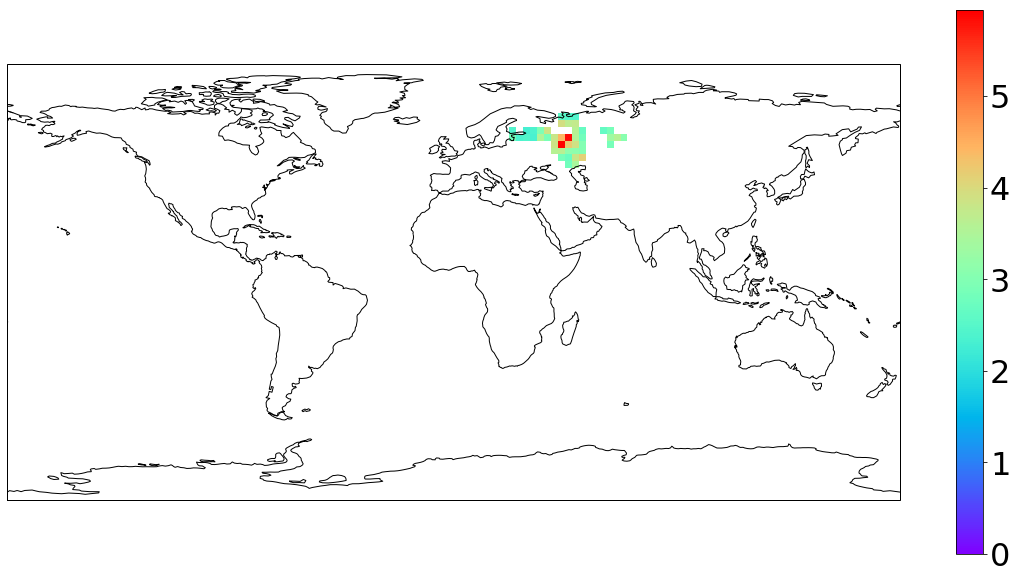

In [58]:
## calculate maximum amplitude of events at each grid cell

piCstd=np.std(piControl, axis=0)
climchange_abs=np.abs(climchange)
climchange_maxabs=np.max(climchange_abs, axis=0)

maxm=np.nanmax(m, axis=0)*maxm
magnitude_climchange=climchange_maxabs*maxm

plot_plate_carree(box, magnitude_climchange, cmap=my_cmap, vmin=1e-30)

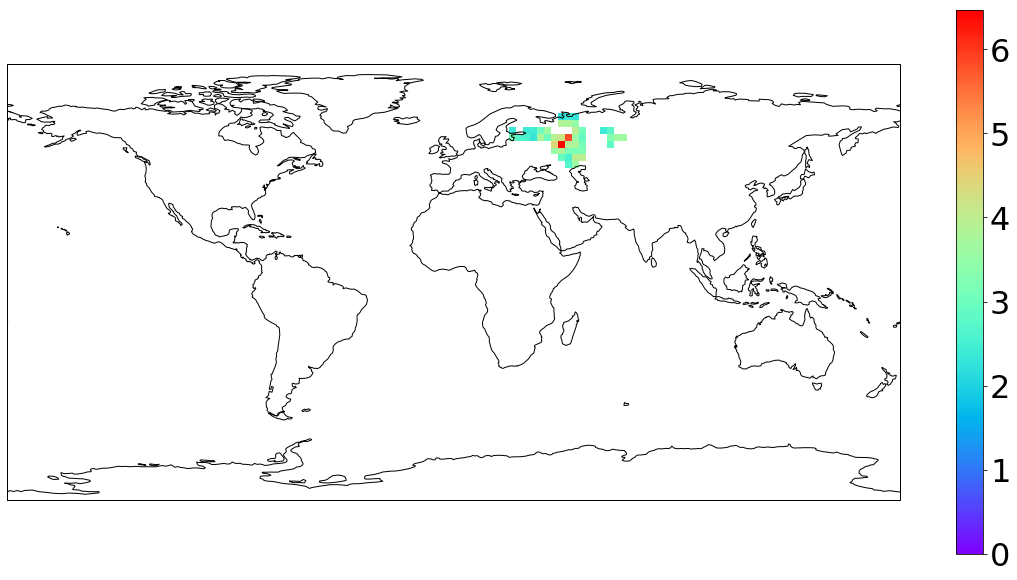

In [59]:
## calculate maximum amplitude of events at each grid cell relative to piC std

ratio=climchange_maxabs/piCstd*maxm

plot_plate_carree(box, ratio, cmap=my_cmap, vmin=1e-30)

## in what year does largest extremum occur: 

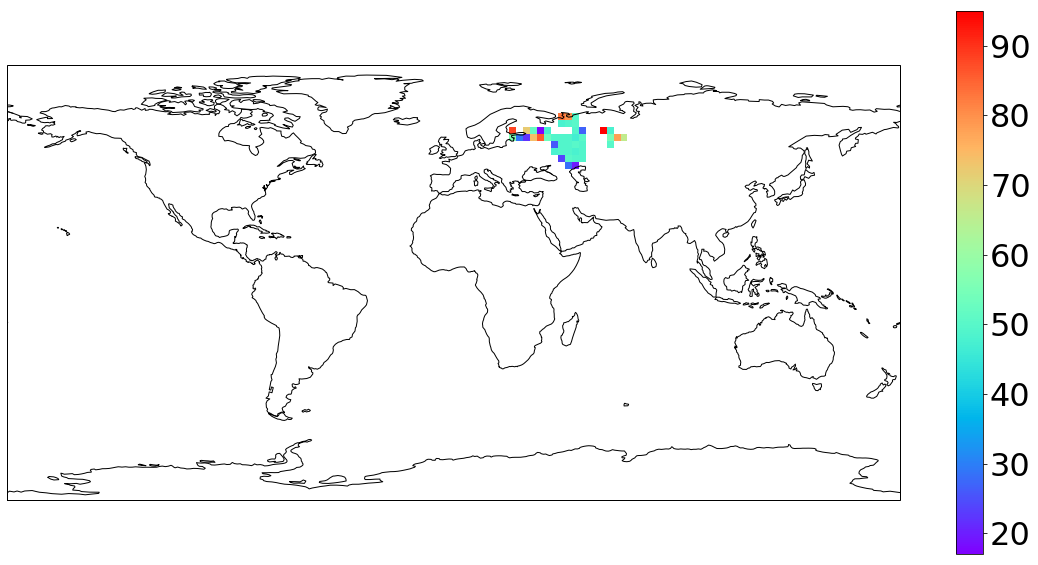

In [60]:
mask_max=m*0
for lonind in range(0,lons):
    for latind in range(0,lats):
        for timeind in range(0,times):
            if climchange_abs[timeind, latind, lonind] == climchange_maxabs[latind,lonind]:
                mask_max[timeind, latind, lonind] = 1

years=linspace(1,times,times)
   
years_maxpeak=(years[:,None,None]*mask_max).max(axis=0)

years_maxpeak=years_maxpeak*maxm

minval = np.min(years_maxpeak[np.nonzero(years_maxpeak)])
maxval= np.max(years_maxpeak)
plot_plate_carree(yearly_box, years_maxpeak,  cmap=my_cmap, vmin=minval, vmax=maxval)


In [61]:
## Show the time series of the original data at the grid cell with the largest outlier

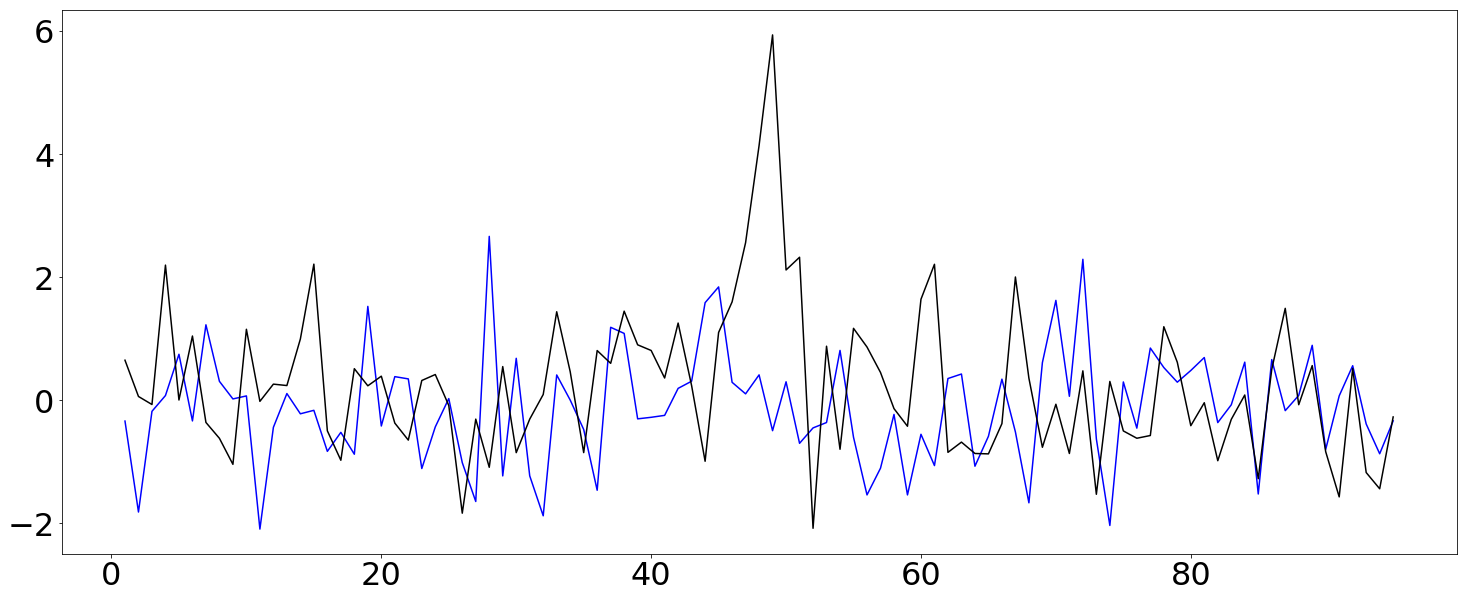

In [62]:
lonind=np.nanargmax(np.nanmax(ratio, axis=0))
latind=np.nanargmax(np.nanmax(ratio, axis=1))
ts=climchange[:,latind,lonind]
ts_ctl=piControl[:,latind,lonind]

#ts_smooth=smooth_data[:,latind,lonind]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(years, ts_ctl, 'b', years, ts, 'k')